In [1]:
from dotenv import load_dotenv
bashrc = "/home/olivia/.bashrc"
load_dotenv(bashrc)
import time
from concurrent.futures import ThreadPoolExecutor
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import random

Python-dotenv could not parse statement starting at line 9
Python-dotenv could not parse statement starting at line 10
Python-dotenv could not parse statement starting at line 12
Python-dotenv could not parse statement starting at line 13
Python-dotenv could not parse statement starting at line 18


In [2]:
import anthropic
anthropic = anthropic.Anthropic()

In [69]:
def load_cache():
    with open('errors_over_time_cache.py', 'r') as f:
        return json.loads(f.read())


cache = load_cache()

def save_cache():
     with open('errors_over_time_cache.py', 'w') as f:
        return json.dumps(cache)

def query_llm(prompt, max_tokens):
    # response = anthropic.messages.create(
    #     model='claude-1.2-instant',
    #     max_tokens=max_tokens,
    #     messages=messages,
    #     temperature=0,
    #     # claude API: https://docs.anthropic.com/claude/reference/messages_post
    # ).content[0].text
    if prompt in cache:
        return cache[prompt]
    response =anthropic.completions.create(
        model="claude-instant-1.2",
        max_tokens_to_sample=max_tokens,
        prompt=prompt,
        temperature=0,
    )
    cache[prompt] = response.completion
    return response.completion




# Tasks

In [119]:
def count_idx(special_idx=3, seq_len=5, special_prob=.25):
    seq = []
    count = 0
    for i in range(seq_len):
        if np.random.uniform() < special_prob:
            seq.append(str(special_idx))
            count += 1
        else:
            seq.append(str(random.choice([i for i in range(10) if not i == special_idx])))
    return {
        'seq': ' '.join(seq),
        'answer': count,
    }
def make_count_idx_description(special_idx):
    return f'Your job is to count the number of times {special_idx} appears each sequence.'



data_size = 100
dataset = pd.DataFrame([count_idx() for _ in range(data_size)])
task_description = make_count_idx_description(3)

# Check

In [105]:
def make_prompt(example_points, query_points, task_description):
    example_list = []
    questions = pd.concat([example_points, query_points])['seq']
    example_answers = example_points['answer']
    for i, example in enumerate(questions):
        example_list.append(f'{i}: {example}')
    example_str = '\n'.join(example_list)
    
    answer_list = []
    for i, answer in enumerate(example_answers):
        answer_list.append(f'{i}: {example_points.iloc[i]["seq"]} -> {answer}')
    answer_list.append(f'{i+1}:')
    answer_str = '\n'.join(answer_list)
    
    prompt=f"""

Human: {task_description}

Here are the questions:
{example_str}

Assistant:
{answer_str}"""
    return prompt


def analyze_responses(prompt, response, ground_truth):
    last_line = prompt.split('\n')[-1]
    response = last_line + response
    start_idx = int(last_line.split(':')[0])
    response_lines = response.split('\n')
    error_idxs = []
    response_counts = {
        'correct_input': 0,
        'correct_label': 0,
        'correct_overall': 0,
    }
    for i in range(min(len(ground_truth), len(response_lines))):
        idx = start_idx + i
        pred = response_lines[i] 
        true = ground_truth.iloc[i]
        try:
            generated_input = pred[pred.index(':') + 1:pred.index('->')].strip()
            if generated_input == true['seq']:
                response_counts['correct_input'] += 1
        except Exception as e:
            pass
        try:
            generated_label = pred[pred.index('->') + 2:].strip()
            if generated_label == str(true['answer']):
                response_counts['correct_label'] += 1
        except:
            pass
        true_str = f'{idx}: {true["seq"]} -> {true["answer"]}'
        if pred == true_str:
            response_counts['correct_overall'] += 1
        else:
            error_idxs.append(i)
    metrics_dict = {key: count / len(ground_truth) for key, count in response_counts.items()}
    metrics_dict['error_idxs'] = tuple(error_idxs)
    return metrics_dict


def process_batch(example_points, query_points, task_description):
    prompt = make_prompt(example_points, query_points, task_description)
    response = query_llm(prompt, 1000)
    metrics_dict = analyze_responses(prompt, response, query_points)
    return metrics_dict
    


def run_exp(example_points, dataset, num_queries_per_batch, num_batches, task_description):
    if len(dataset) < num_queries_per_batch * num_batches:
        raise ValueError(f'dataset is too short')
    results = []
    futures = []
    with ThreadPoolExecutor() as executor:
        for i in range(num_batches):
            query_points = dataset.iloc[i * num_queries_per_batch:(i+1) * num_queries_per_batch]
            # results.append(process_batch(example_points, query_points))
            futures.append(executor.submit(process_batch, example_points=example_points, query_points=query_points, task_description=task_description))
        for fut in futures:
            results.append(fut.result())
        
    save_cache()
    return pd.DataFrame(results)
    

In [93]:
num_queries_per_batch = 10
num_batches = 20
num_examples = 10
# example_points = pd.DataFrame([count_idx() for _ in range(num_examples)])
# dataset = pd.DataFrame([count_idx() for _ in range(num_queries_per_batch * num_batches)])

In [94]:
out = run_exp(example_points, dataset, num_queries_per_batch, num_batches, task_description)

In [155]:
len(out)

20

In [157]:
out

,correct_input,correct_label,correct_overall,error_idxs
0,1.0,0.7,0.7,"(3, 4, 7)"
1,1.0,0.4,0.4,"(1, 2, 3, 4, 5, 6)"
2,1.0,0.8,0.8,"(0, 2)"
3,1.0,0.7,0.7,"(4, 6, 9)"
4,1.0,0.5,0.5,"(2, 3, 7, 8, 9)"
5,1.0,0.8,0.8,"(5, 9)"
6,1.0,0.7,0.7,"(1, 5, 7)"
7,1.0,0.7,0.7,"(6, 7, 9)"
8,1.0,0.6,0.6,"(5, 6, 8, 9)"
9,1.0,0.6,0.6,"(0, 4, 5, 9)"


In [98]:
num_examples = 10

In [99]:
error_idxs = np.random.permutation(num_examples)
print(error_idxs)

[0 9 2 7 5 8 4 6 3 1]


In [117]:
def generate_datasets_with_extra_errors(zero_errors):
    error_idxs = np.random.permutation(len(zero_errors))
    example_points_with_errors = [zero_errors]
    for error_idx in error_idxs:
        new_example_points = example_points_with_errors[-1].copy()
        row = new_example_points.iloc[error_idx]
        if row['answer'] == 0 or np.random.uniform() > .5:
            new_example_points.loc[error_idx, 'answer'] += 1
        else:
            new_example_points.loc[error_idx, 'answer'] -= 1
        example_points_with_errors.append(new_example_points)
    return example_points_with_errors

In [171]:
# separately run 3 different tasks; don't consider these together
# for each task:
#     - each set of examples is 10
#     - 10 diff 'base' examples
#     - adding errors by 2
#     - for each set of examples, generate 10 20 different datasets of 20 each

def plot_accuracies(df_dict):
    x = df_dict.keys()
    y = [
        np.mean([df['correct_overall'].mean() for df in df_list])
            for df_list in df_dict.values()
    ]
    y_err = [
        np.std([df['correct_overall'].mean() for df in df_list])
            for df_list in df_dict.values()
    ]
    y_counts = [
        sum([len(df['correct_overall']) for df in df_list])
            for df_list in df_dict.values()
    ]
    print(y_counts)
    plt.errorbar(x, y, y_err)
    plt.xlabel('Number of errors in the prompt')
    plt.ylabel('Task accuracy')
    plt.title('How does accuracy change with errors in past completions?')
    plt.show()

def plot_idx(df_dict, max_idx):
    count_dicts = {} 
    all_y_vals = []
    for n_err, df_list in df_dict.items():
        for df in df_list:
            counts = 0
            error_idx_dict = defaultdict(int)
            for error_idxs in df['error_idxs']:
                counts += 1
                for idx in error_idxs:
                    error_idx_dict[idx] += 1
            x = np.arange(max_idx)
            y = [error_idx_dict[key]/counts for key in x]
            y_mean = np.mean(y)
            print(f'y_mean', y_mean)
            y = [y_val - y_mean for y_val in y]
            all_y_vals.append(y)
        
    y_arr = np.array(all_y_vals)
    y_mean = np.mean(y_arr, axis=0)
    y_std = np.std(y_arr, axis=0)
    plt.errorbar(x, y_mean, y_std)
    plt.xlabel('Sample Generation idx')
    plt.ylabel('Accuracy (minus mean)')
    plt.show()
    


def run_task_exp_and_analysis(*, num_examples_per_set=10, num_batches=20, error_interval=2, num_queries_per_batch=20, num_example_sets=10, seed=0, generate_fn=count_idx, task_description=task_description):
    n_errors = np.arange(0, num_examples_per_set, error_interval)
    all_results_dict = {n_err: [] for n_err in n_errors}
    for i in range(num_example_sets):
        random.seed(i)
        np.random.seed(i)
        example_points = pd.DataFrame([generate_fn() for _ in range(num_examples_per_set)])
        all_example_points = generate_datasets_with_extra_errors(example_points)[::error_interval]
        dataset = pd.DataFrame([count_idx() for _ in range(num_queries_per_batch * num_batches)])
        for ex_points, n_err in zip(all_example_points, n_errors):
            result_df = run_exp(ex_points, dataset, num_queries_per_batch, num_batches)
            all_results_dict[n_err].append(result_df)
    
    return all_results_dict
    
    


    
    
    

In [142]:
all_results = run_task_exp_and_analysis(num_examples_per_set=10, 
                         num_batches=20, 
                         error_interval=2, 
                         num_queries_per_batch=20, 
                         num_example_sets=10, 
                         seed=0, 
                         generate_fn=count_idx, 
                         task_description=task_description)

In [154]:
dl = all_results[0]
print(len(dl[0]))

20


[200, 200, 200, 200, 200]


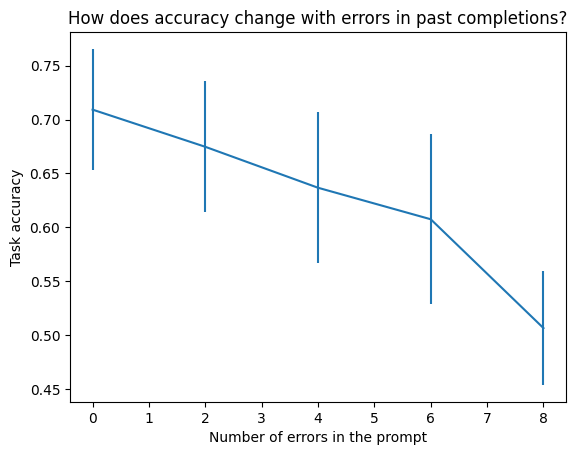

In [151]:
plot_accuracies(all_results)

y_mean 0.35500000000000004
y_mean 0.195
y_mean 0.255
y_mean 0.265
y_mean 0.28
y_mean 0.31500000000000006
y_mean 0.23000000000000004
y_mean 0.31
y_mean 0.16999999999999998
y_mean 0.165
y_mean 0.355
y_mean 0.22999999999999998
y_mean 0.30000000000000004
y_mean 0.29500000000000004
y_mean 0.3
y_mean 0.32999999999999996
y_mean 0.20999999999999996
y_mean 0.31999999999999995
y_mean 0.23499999999999996
y_mean 0.15999999999999998
y_mean 0.385
y_mean 0.38
y_mean 0.44000000000000006
y_mean 0.315
y_mean 0.38
y_mean 0.34
y_mean 0.25
y_mean 0.31500000000000006
y_mean 0.24499999999999997
y_mean 0.15
y_mean 0.355
y_mean 0.38500000000000006
y_mean 0.43000000000000005
y_mean 0.475
y_mean 0.42000000000000004
y_mean 0.355
y_mean 0.29000000000000004
y_mean 0.35
y_mean 0.295
y_mean 0.16499999999999998
y_mean 0.495
y_mean 0.5700000000000001
y_mean 0.44000000000000006
y_mean 0.465
y_mean 0.495
y_mean 0.53
y_mean 0.34500000000000003
y_mean 0.495
y_mean 0.5249999999999999
y_mean 0.395


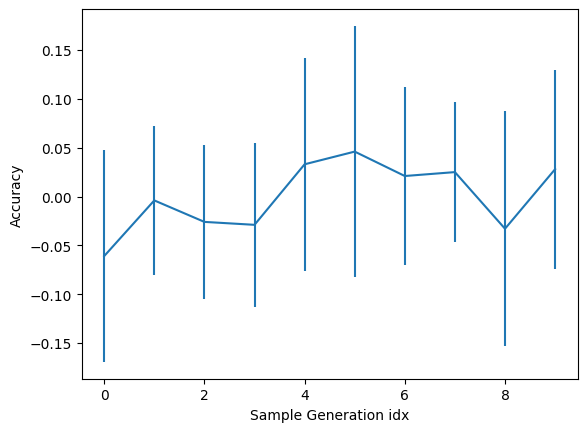

In [170]:
plot_idx(all_results, 10)

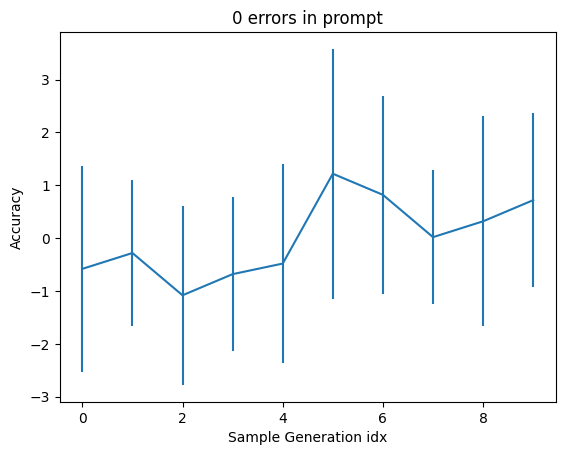

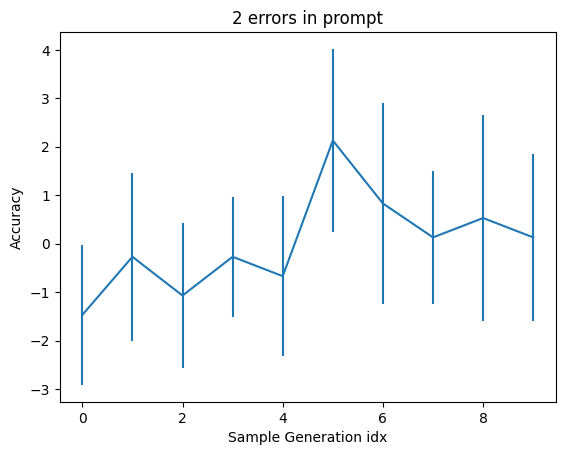

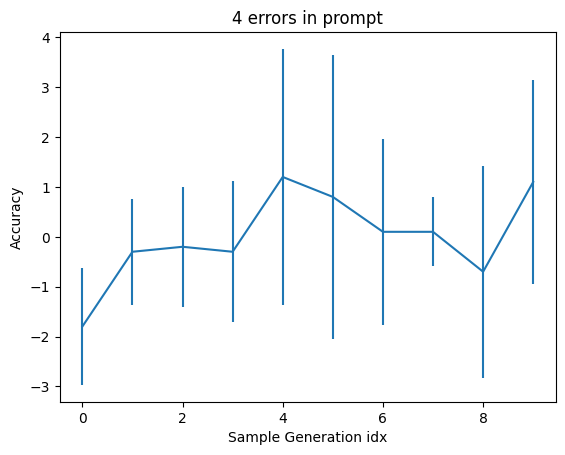

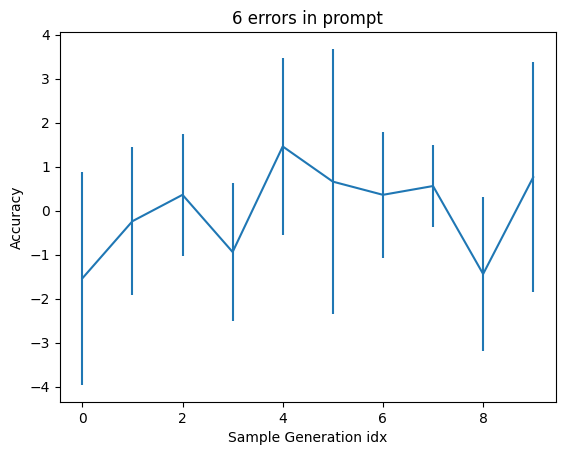

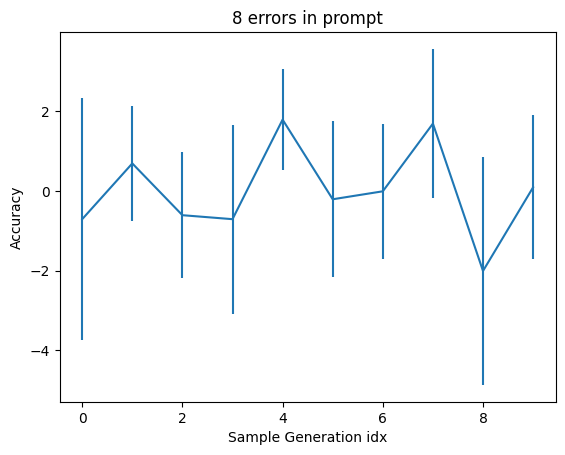

KeyError: 10

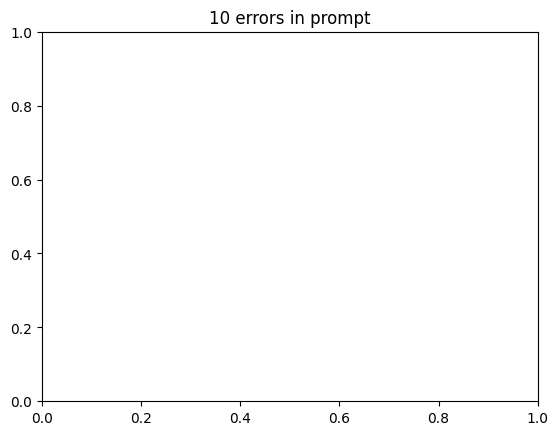

In [166]:
for i in range(0, 11, 2):
    plt.title(f'{i} errors in prompt')
    plot_idx({i: all_results[i]}, 10)

In [106]:
exp_results = [run_exp(ex_points_errs, dataset, num_queries_per_batch, num_batches) for ex_points_errs in example_points_with_errors]

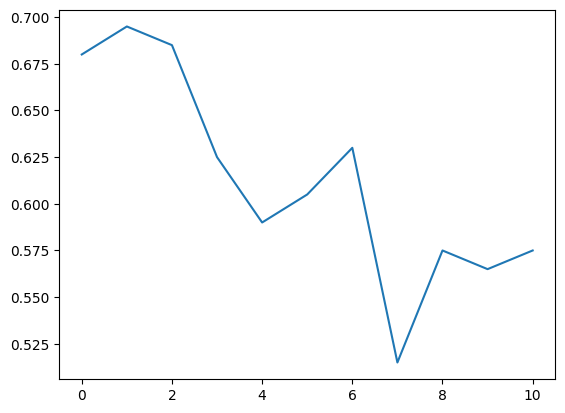

In [110]:
accuracies = [df['correct_overall'].mean() for df in exp_results]
print(accuracies)
plt.plot(np.arange(len(accuracies)), accuracies)
plt.show()

In [115]:
from collections import defaultdict

def plot_idx(df):
    error_idx_dict = defaultdict(int)
    for error_idxs in df['error_idxs']:
        for idx in error_idxs:
            error_idx_dict[idx] += 1
    x = np.arange(max(error_idx_dict.keys()))
    y = [error_idx_dict[key] for key in x]
    plt.scatter(x, y)
    plt.show()
    
    

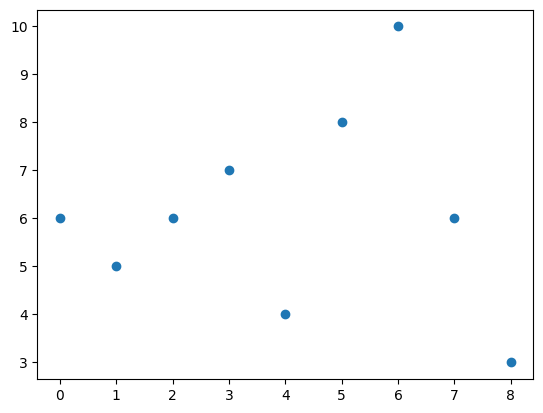

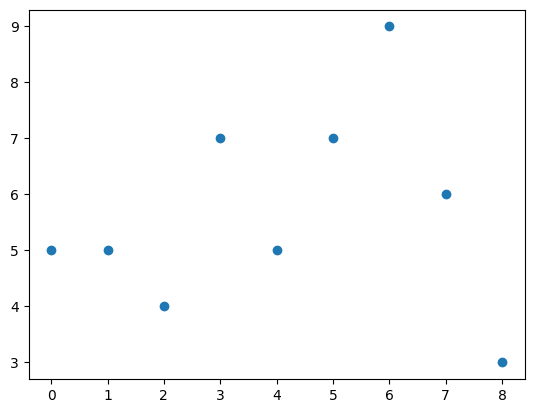

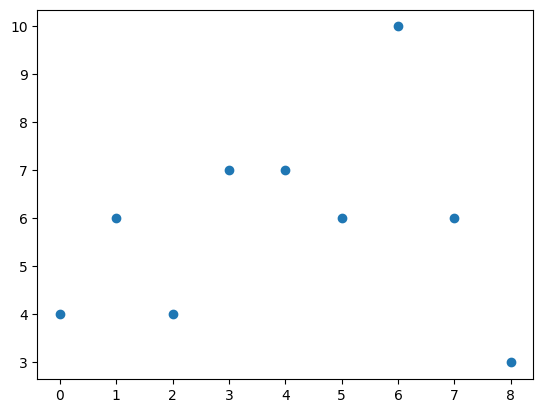

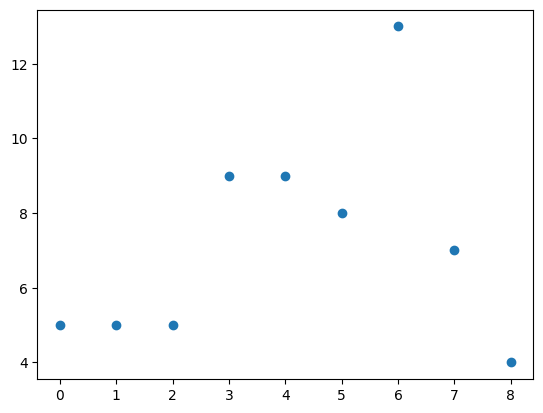

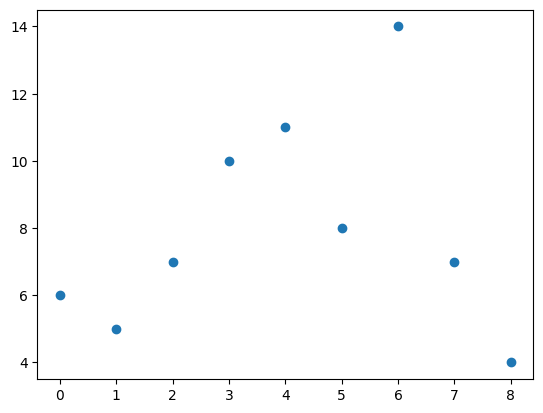

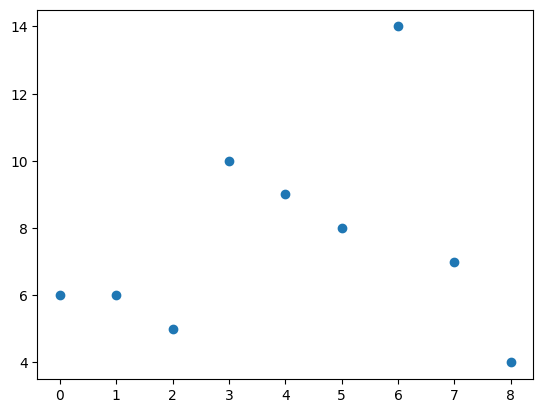

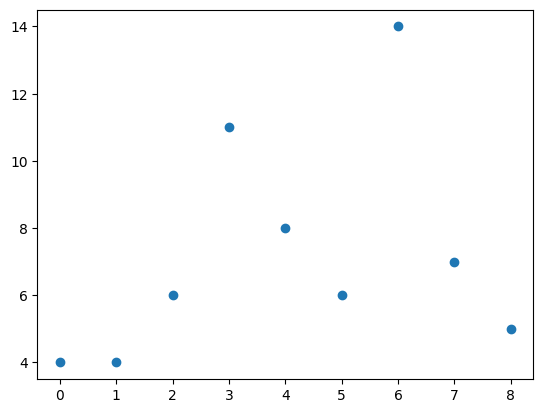

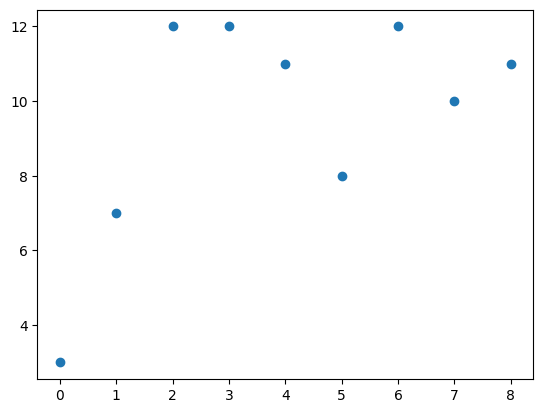

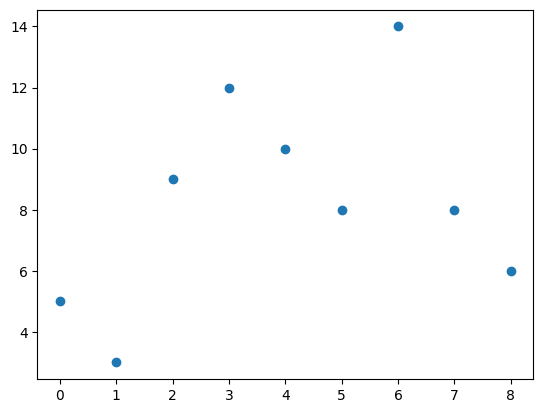

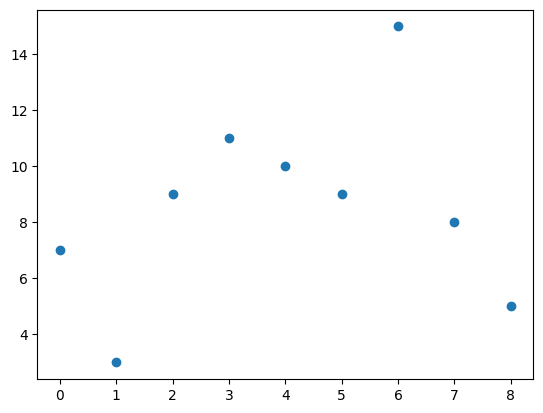

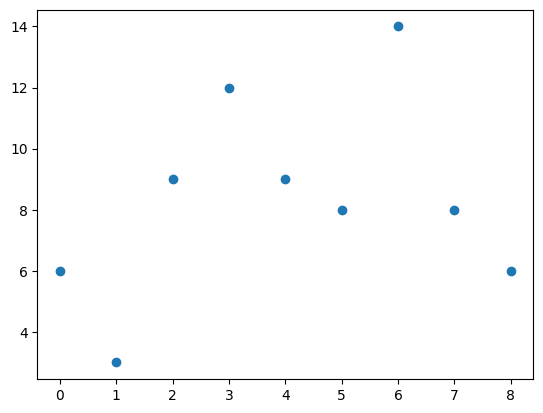

In [116]:
for df in exp_results:
    plot_idx(df)

# - make results more reliable
# > more tasks 
# > more seeds


# exp 2: plot idxs
